In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d

In [34]:
# ------------------------------
# Parameters
# ------------------------------
T = 1.0
N_t = 20
dt = T / N_t

S0 = 100.0
sigma = 0.3
alpha = 0.06
r = 0.04
K = 100.0
gamma = 0.1
lambda_tc = 0.01

pi_vals = np.linspace(-2, 2, 100)

u = np.exp(sigma * np.sqrt(dt))
d = np.exp(-sigma * np.sqrt(dt))
p = (np.exp(alpha * dt) - d) / (u - d)

# ------------------------------
# Wealth Grid
# ------------------------------
W_min, W_max = 20.0, 150.0
N_W = 400
W_grid = np.linspace(W_min, W_max, N_W)

# ------------------------------
# Utility Function
# ------------------------------
def utility(x):
    return max(x,1e-8)**gamma / gamma if x > 0 else -1e12

# ------------------------------
# Interpolation Helper
# ------------------------------
def interp_value(W_new, grid, values):
    return np.interp(W_new, grid, values)

# 1 No transaction costs

## 1.1 No transaction costs and no option

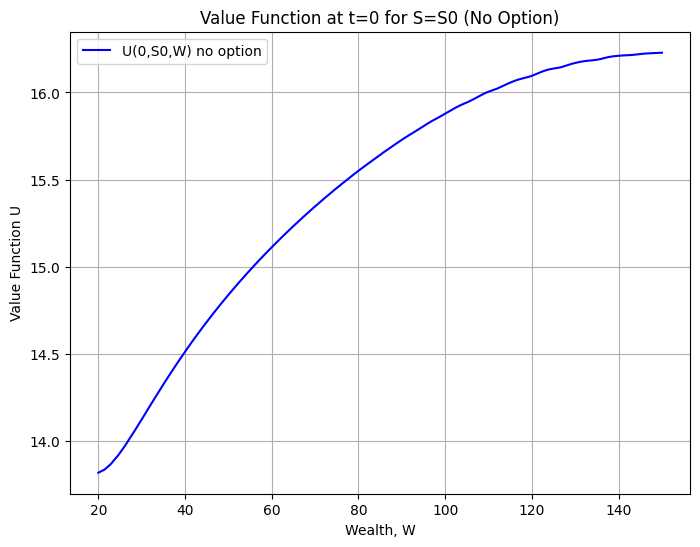

In [35]:
# ==============================
# Part 1: No Transaction Costs
# ==============================

# ------------------------------
# Terminal Utility without Option
# ------------------------------
def terminal_utility_no_option(S):
    return np.array([utility(W) for W in W_grid])

# ------------------------------
# Dynamic Programming Solver (No Transaction Costs, No Option)
# ------------------------------

# ------------------------------
# SPSA Optimizer (1D)
# ------------------------------
def spsa_optimize(objective_function, initial_pi, a=0.6, c=0.2, alpha=0.602, gamma=0.101, A=10, max_iter=50):
    pi = initial_pi
    for k in range(1, max_iter + 1):
        ak = a / ((A + k) ** alpha)
        ck = c / (k ** gamma)
        delta = np.random.choice([-1, 1])
        pi_plus = pi + ck * delta
        pi_minus = pi - ck * delta

        # Optional bounds for safety
        pi_plus = np.clip(pi_plus, -3, 4)
        pi_minus = np.clip(pi_minus, -3, 4)

        loss_plus = objective_function(pi_plus)
        loss_minus = objective_function(pi_minus)

        gk = (loss_plus - loss_minus) / (2.0 * ck * delta)
        pi = pi - ak * gk

        # Optional projection back into bounds
        pi = np.clip(pi, -3, 4)

    return pi

# ------------------------------
# DP Solver using SPSA
# ------------------------------
def solve_dp_no_transaction_cost(terminal_utility_func):
    U = {}
    Pi = {}

    for i in range(N_t + 1):
        S_val = S0 * (u ** i) * (d ** (N_t - i))
        U[(N_t, i)] = terminal_utility_func(S_val)
        Pi[(N_t, i)] = np.zeros(N_W)

    for n in reversed(range(N_t)):
        for i in range(n + 1):
            S_val = S0 * (u ** i) * (d ** (n - i))
            U_val = np.zeros(N_W)
            Pi_val = np.zeros(N_W)

            # Precompute interpolators for cubic interpolation
            from scipy.interpolate import interp1d
            U_up_interp = interp1d(W_grid, U[(n + 1, i + 1)], kind='cubic', fill_value="extrapolate", bounds_error=False)
            U_down_interp = interp1d(W_grid, U[(n + 1, i)], kind='cubic', fill_value="extrapolate", bounds_error=False)

            for j, W in enumerate(W_grid):
                def objective_pi(pi):
                    W_up = W * (1 + r * dt + pi * ((alpha - r) * dt + sigma * np.sqrt(dt)))
                    W_down = W * (1 + r * dt + pi * ((alpha - r) * dt - sigma * np.sqrt(dt)))
                    W_up = np.clip(W_up, W_min, W_max)
                    W_down = np.clip(W_down, W_min, W_max)
                    U_up = U_up_interp(W_up)
                    U_down = U_down_interp(W_down)
                    return -(p * U_up + (1 - p) * U_down)

                # Run SPSA to find optimal pi
                best_pi = spsa_optimize(objective_pi, initial_pi=1)
                best_val = -objective_pi(best_pi)

                U_val[j] = best_val
                Pi_val[j] = best_pi

            U[(n, i)] = U_val
            Pi[(n, i)] = Pi_val

    return U, Pi

# ------------------------------
# Solve and Plot (No Option)
# ------------------------------
U_no_opt, Pi_no_opt = solve_dp_no_transaction_cost(terminal_utility_no_option)

plt.figure(figsize=(8, 6))
plt.plot(W_grid, U_no_opt[(0, 0)], 'b-', label="U(0,S0,W) no option")
plt.xlabel("Wealth, W")
plt.ylabel("Value Function U")
plt.title("Value Function at t=0 for S=S0 (No Option)")
plt.legend()
plt.grid(True)
plt.show()

In [39]:
Pi_no_opt

{(20,
  0): array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 

In [40]:
Pi_theo = np.full((N_W,N_t),(alpha-r)/(sigma**2*(1-gamma))) 

<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
/var/folders/3_/t8l3yh8s28z9_jbq7gqy7byr0000gn/T/ipykernel_88278/3283079188.py:5: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("$\pi")


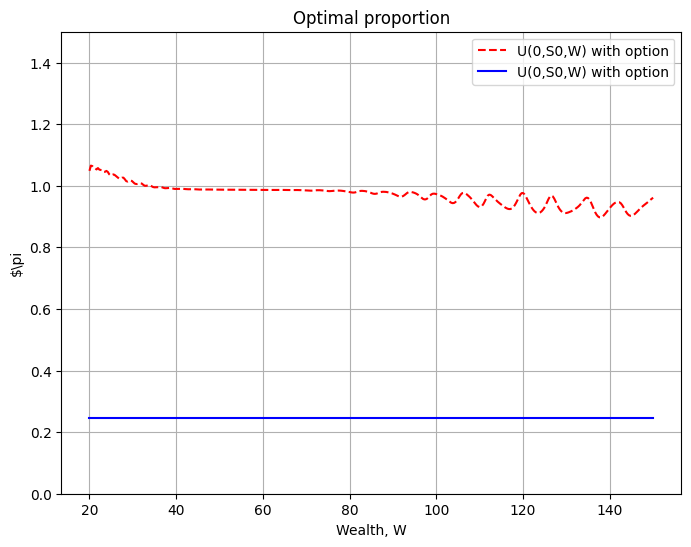

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(W_grid, Pi_no_opt[(0, 0)], 'r--', label="U(0,S0,W) with option")
plt.plot(W_grid, Pi_theo[:,0], 'b-', label="U(0,S0,W) with option")
plt.xlabel("Wealth, W")
plt.ylabel("$\pi")
plt.ylim((0,1.5))
plt.title("Optimal proportion")
plt.legend()
plt.grid(True)
plt.show()


## 1.2 No transaction costs and option

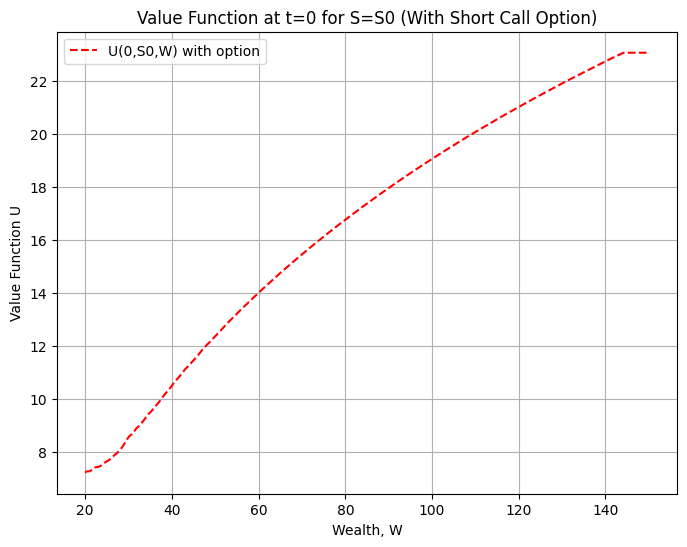

In [28]:
# ------------------------------
# Terminal Utility with Option
# ------------------------------

def terminal_utility_with_option(S):
    payoff = max(S - K, 0.0)
    return np.array([utility(max(W - payoff, 1e-8)) for W in W_grid])

# ------------------------------
# Solve and Plot (With Option)
# ------------------------------
U_with_opt, Pi_with_opt = solve_dp_no_transaction_cost(terminal_utility_with_option)

plt.figure(figsize=(8, 6))
plt.plot(W_grid, U_with_opt[(0, 0)], 'r--', label="U(0,S0,W) with option")
plt.xlabel("Wealth, W")
plt.ylabel("Value Function U")
plt.title("Value Function at t=0 for S=S0 (With Short Call Option)")
plt.legend()
plt.grid(True)
plt.show()


## 1.3 Indifference pricing

In [29]:
# ------------------------------
# Black-Scholes Call Price Function
# ------------------------------
def call_price(t, S, T, r, sigma, K):
    tau = T - t
    if tau < 1e-8:
        return max(S - K, 0)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    return S * norm.cdf(d1) - K * np.exp(-r*tau) * norm.cdf(d2)

def Delta(t, S, T, r, sigma, K):
    tau = T-t 
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
    return norm.cdf(d1)

Optimal C (Indifference price) = 14.530588393438128
Black-Scholes price = 13.753264647243569
Delta Black-Scholes = 0.6115393362947339


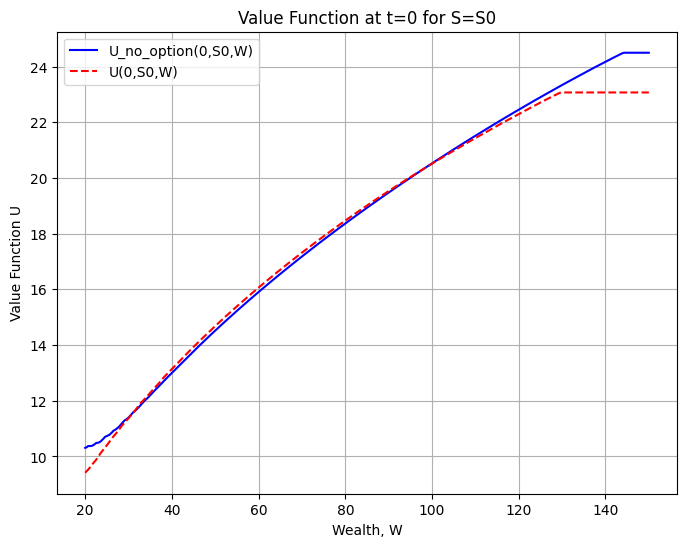

In [30]:
# ------------------------------
# Indifference Pricing
# ------------------------------

def shifted_utility(C):
    W_shifted = W_grid + C
    U_shifted = np.interp(W_shifted, W_grid, U_with_opt[(0, 0)])
    error = np.sqrt(np.mean((U_shifted - U_no_opt[(0, 0)])**2))
    return error

res = minimize_scalar(shifted_utility, bounds=(0, 20), method='bounded')
C_optimal = res.x
print("Optimal C (Indifference price) =", C_optimal)
print("Black-Scholes price =", call_price(0,S0,T,r,sigma,K))
print('Delta Black-Scholes =', Delta(0,S0,T,r,sigma,K))

C = C_optimal
W_shifted = W_grid + C
U_min = np.interp(W_shifted, W_grid, U_with_opt[(0, 0)])


plt.figure(figsize=(8,6))
plt.plot(W_grid, U_no_opt[(0, 0)], 'b-', label="U_no_option(0,S0,W)")
plt.plot(W_grid, U_min, 'r--', label="U(0,S0,W)")
plt.xlabel("Wealth, W")
plt.ylabel("Value Function U")
plt.title("Value Function at t=0 for S=S0")
plt.legend()
plt.grid(True)
plt.show()


## 1.4 Comparison with theoretical values

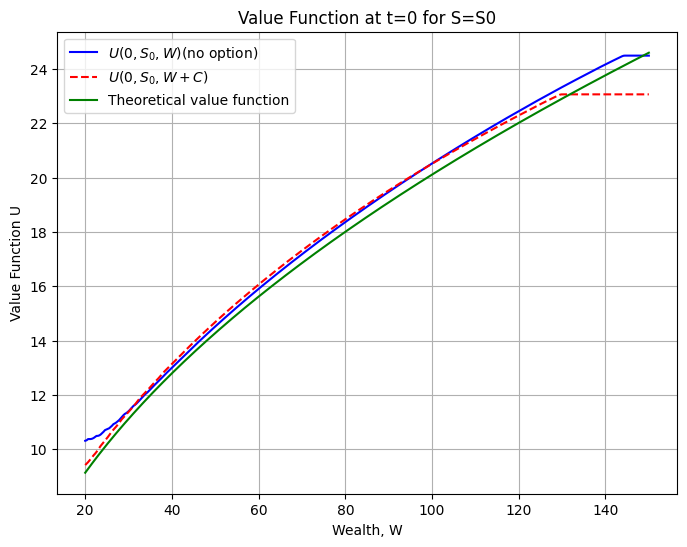

In [31]:
# ------------------------------
# Theoretical U function
# ------------------------------

def U_explicit(t,T,r,alpha,sigma,S,W,gamma,K):
    v = (1/2)*(((alpha-r)/sigma)**2)*(1/(1-gamma)) + r
    g = np.exp(v*r*(T-t))
    return g*((W)**gamma)/gamma

def U_explicit_opt(t,T,r,alpha,sigma,S,W,gamma,K):
    v = (1/2)*(((alpha-r)/sigma)**2)*(1/(1-gamma)) + r
    g = np.exp(v*r*(T-t))
    f = call_price(t, S, T, r, sigma, K)
    return g*((W-f)**gamma)/gamma

W_shifted = W_grid + C
U_theo = [U_explicit_opt(0,T,r,alpha,sigma,S0,W,gamma,K) for W in W_shifted]

plt.figure(figsize=(8,6))
plt.plot(W_grid, U_no_opt[(0, 0)], 'b-', label=r"$U(0,S_0,W)$(no option)")
plt.plot(W_grid, U_min, 'r--', label=r"$U(0,S_0,W+C)$")
plt.plot(W_grid, U_theo, 'g-', label = 'Theoretical value function')
#plt.plot(W_grid, U_with_opt[(0, 0)], 'r--', label=r"$U(0,S_0,W)$")
plt.xlabel("Wealth, W")
plt.ylabel("Value Function U")
plt.title("Value Function at t=0 for S=S0")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# ------------------------------
# Theoretical pi values when there is no position in option
# ------------------------------

Pi_theo = np.full((N_W,N_t),(alpha-r)/(sigma**2*(1-gamma))) 

# ------------------------------
# Theoretical pi values when there is a position in option
# ------------------------------

Pi_theo_opt = {}
for n in reversed(range(N_t)):
    for i in range(n+1): 
        S_val = S0 * (u**i) * (d**(n - i))
        Price = call_price(0, S_val, (N_t-n)/N_t, r, sigma, K)  
        Delt = Delta(0, S_val, (N_t-n)/N_t, r, sigma, K)
        Pi_vals = np.zeros(N_W)
        for j, W in enumerate(W_grid):
            Pi_vals[j] = (alpha-r)/(sigma**2*(1-gamma))*((W-Price)/W)+(Price/W)*Delt
        Pi_theo_opt[(n,i)] = Pi_vals
        
# ------------------------------
# Proportion for BS Delta Hedging
# ------------------------------

Delt = Delta(0,S0,T,r,sigma,K)
Pi_delta_0 = [min((Delt*S0)/W,4) for W in W_grid] 
print('Delta Black-Scholes =', Delt)

Delta Black-Scholes = 0.6115393362947339


<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
/var/folders/3_/t8l3yh8s28z9_jbq7gqy7byr0000gn/T/ipykernel_88278/1117343788.py:2: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(W_grid, Pi_with_opt[(0, 0)], label='$\pi$ with option', lw=2)
/var/folders/3_/t8l3yh8s28z9_jbq7gqy7byr0000gn/T/ipykernel_88278/1117343788.py:3: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(W_grid, Pi_theo_opt[(0,0)], label="$\pi$ with option (theoretical)")
/var/folders/3_/t8l3yh8s28z9_jbq7gqy7byr0000gn/T/ipykernel_88278/1117343788.py:4: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(W_grid, Pi_delta_0, label = '$\pi$ from BS Delta Hedging')


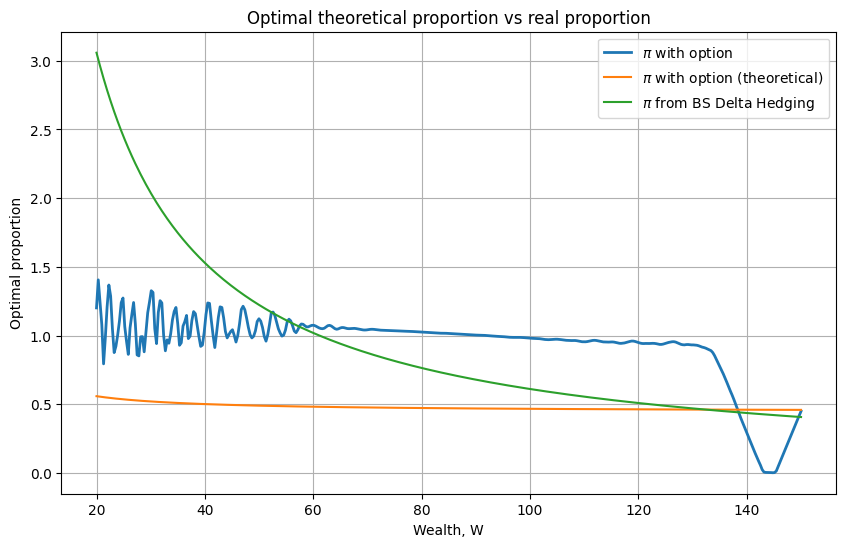

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(W_grid, Pi_with_opt[(0, 0)], label='$\pi$ with option', lw=2)
plt.plot(W_grid, Pi_theo_opt[(0,0)], label="$\pi$ with option (theoretical)")
plt.plot(W_grid, Pi_delta_0, label = '$\pi$ from BS Delta Hedging')
plt.xlabel("Wealth, W")
plt.ylabel("Optimal proportion")
plt.title("Optimal theoretical proportion vs real proportion")
plt.legend()
plt.grid(True)
plt.show()

## 1.5 Trying with different values 

In [94]:
# ---------------------------
# Parameters to twitch 
# ---------------------------
alpha = 0.05
K = 100.0
lambda_tc = 0.01
pi_vals = np.linspace(-3, 4, 100)


Optimal C (Indifference price) = 7.676162037612947
Black-Scholes price = 9.413403383853016
Delta Black-Scholes = 0.5987063256829237


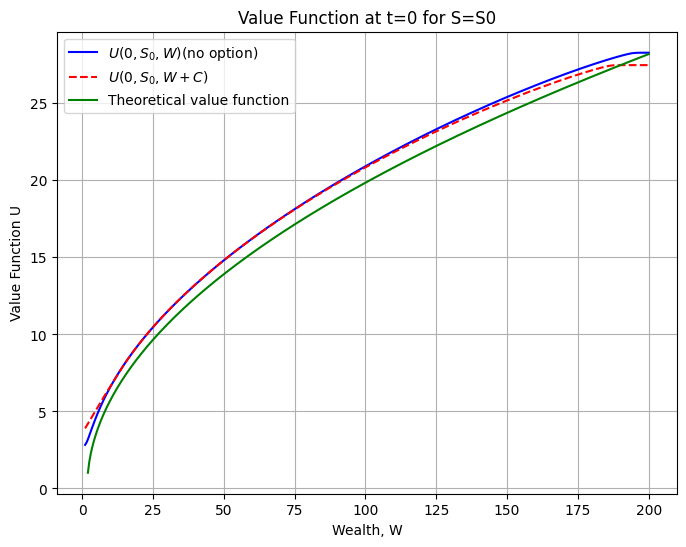

In [95]:
U_no_opt, Pi_no_opt = solve_dp_no_transaction_cost(terminal_utility_no_option)
U_with_opt, Pi_with_opt = solve_dp_no_transaction_cost(terminal_utility_with_option)
def shifted_utility(C):
    W_shifted = W_grid + C
    U_shifted = np.interp(W_shifted, W_grid, U_with_opt[(0, 0)])
    error = np.sqrt(np.mean((U_shifted - U_no_opt[(0, 0)])**2))
    return error
res = minimize_scalar(shifted_utility, bounds=(0, 20), method='bounded')
C_optimal = res.x
print("Optimal C (Indifference price) =", C_optimal)
print("Black-Scholes price =", call_price(0,S0,T,r,sigma,K))
print('Delta Black-Scholes =', Delta(0,S0,T,r,sigma,K))
C = C_optimal
W_shifted = W_grid + C
U_min = np.interp(W_shifted, W_grid, U_with_opt[(0, 0)])

plt.figure(figsize=(8,6))
plt.plot(W_grid, U_no_opt[(0, 0)], 'b-', label=r"$U(0,S_0,W)$(no option)")
plt.plot(W_grid, U_min, 'r--', label=r"$U(0,S_0,W+C)$")
plt.plot(W_grid, U_theo, 'g-', label = 'Theoretical value function')
#plt.plot(W_grid, U_with_opt[(0, 0)], 'r--', label=r"$U(0,S_0,W)$")
plt.xlabel("Wealth, W")
plt.ylabel("Value Function U")
plt.title("Value Function at t=0 for S=S0")
plt.legend()
plt.grid(True)
plt.show()

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
/var/folders/3_/t8l3yh8s28z9_jbq7gqy7byr0000gn/T/ipykernel_19773/1117343788.py:2: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(W_grid, Pi_with_opt[(0, 0)], label='$\pi$ with option', lw=2)
/var/folders/3_/t8l3yh8s28z9_jbq7gqy7byr0000gn/T/ipykernel_19773/1117343788.py:3: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(W_grid, Pi_theo_opt[(0,0)], label="$\pi$ with option (theoretical)")
/var/folders/3_/t8l3yh8s28z9_jbq7gqy7byr0000gn/T/ipykernel_19773/1117343788.py:4: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(W_grid, Pi_delta_0, label = '$\pi$ from BS Delta Hedging')


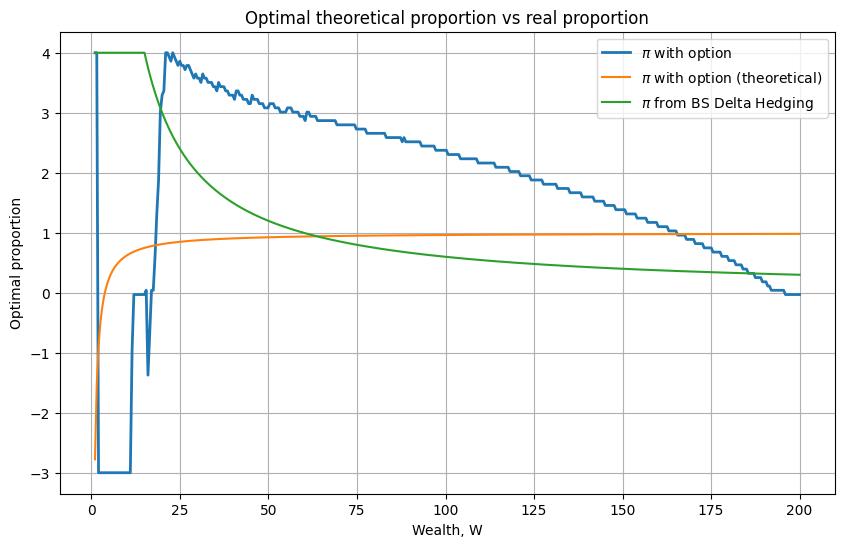

In [96]:
plt.figure(figsize=(10, 6))
plt.plot(W_grid, Pi_with_opt[(0, 0)], label='$\pi$ with option', lw=2)
plt.plot(W_grid, Pi_theo_opt[(0,0)], label="$\pi$ with option (theoretical)")
plt.plot(W_grid, Pi_delta_0, label = '$\pi$ from BS Delta Hedging')
plt.xlabel("Wealth, W")
plt.ylabel("Optimal proportion")
plt.title("Optimal theoretical proportion vs real proportion")
plt.legend()
plt.grid(True)
plt.show()

# 2 With transaction costs

## 2.1 With transaction costs and no option

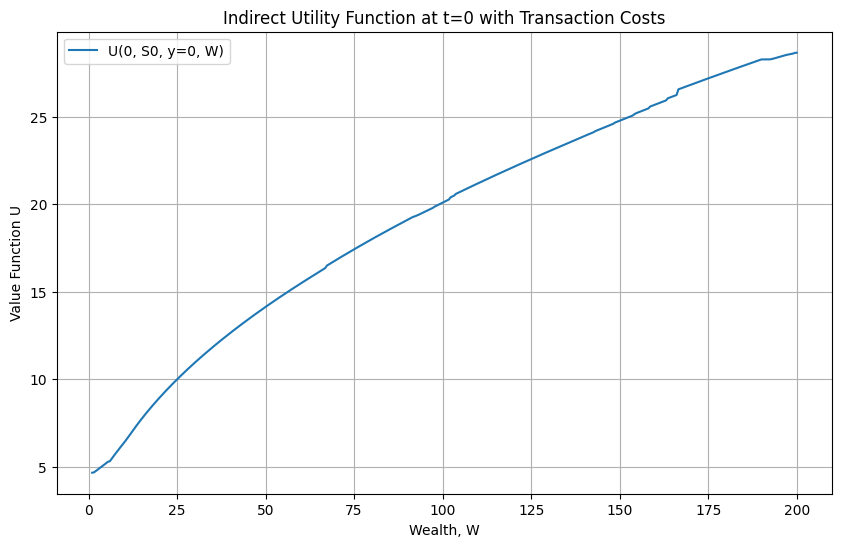

In [97]:
# ==============================
# Part 2: With Transaction Costs (Alternative Scheme)
# ==============================

# ------------------------------
# Dynamic Programming with Transaction Costs (Alternative Step-by-Step Scheme)
# ------------------------------
def solve_dp_with_transaction_cost(option=False):
    Delta_y = 1.0
    M = 10
    y_grid = np.arange(-M, M + 1) * Delta_y
    K_y = len(y_grid)
    N_y = K_y

    U = {}
    for i in range(N_t + 1):
        S_val = S0 * (u ** i) * (d ** (N_t - i))
        U[(N_t, i)] = np.zeros((N_y, N_W))
        for k, y in enumerate(y_grid):
            for j, W in enumerate(W_grid):
                option_payoff = max(S_val - K, 0) if option else 0.0
                liquidation = max(W + S_val * y - lambda_tc * S_val * abs(y) - option_payoff, 1e-8)
                U[(N_t, i)][k, j] = utility(liquidation)

    for n in reversed(range(N_t)):
        for i in range(n + 1):
            S_val = S0 * (u ** i) * (d ** (n - i))
            U_val = np.full((N_y, N_W), -1e10)
            for k, y in enumerate(y_grid):
                for j, W in enumerate(W_grid):
                    # No Transaction
                    W_nt = W * np.exp(r * dt)
                    j_nt = np.argmin(np.abs(W_grid - W_nt))
                    val_up = U[(n + 1, i + 1)][k, j_nt]
                    val_down = U[(n + 1, i)][k, j_nt]
                    val_nt = p * val_up + (1 - p) * val_down

                    # Buy
                    if k < N_y - 1:
                        W_buy = W - (1 + lambda_tc) * S_val * Delta_y
                        W_buy *= np.exp(r * dt)
                        if W_buy >= W_min:
                            j_b = np.argmin(np.abs(W_grid - W_buy))
                            val_buy_up = U[(n + 1, i + 1)][k + 1, j_b]
                            val_buy_down = U[(n + 1, i)][k + 1, j_b]
                            val_buy = p * val_buy_up + (1 - p) * val_buy_down
                        else:
                            val_buy = -1e10
                    else:
                        val_buy = -1e10

                    # Sell
                    if k > 0:
                        W_sell = W + (1 - lambda_tc) * S_val * Delta_y
                        W_sell *= np.exp(r * dt)
                        if W_sell <= W_max:
                            j_s = np.argmin(np.abs(W_grid - W_sell))
                            val_sell_up = U[(n + 1, i + 1)][k - 1, j_s]
                            val_sell_down = U[(n + 1, i)][k - 1, j_s]
                            val_sell = p * val_sell_up + (1 - p) * val_sell_down
                        else:
                            val_sell = -1e10
                    else:
                        val_sell = -1e10

                    U_val[k, j] = max(val_nt, val_buy, val_sell)

            U[(n, i)] = U_val

    return U, y_grid

# ------------------------------
# Solve and Plot Transaction Cost Case (Without Option)
# ------------------------------
U_tc, y_grid = solve_dp_with_transaction_cost(option=False)
k0 = len(y_grid) // 2

plt.figure(figsize=(10, 6))
plt.plot(W_grid, U_tc[(0,0)][k0,:], label="U(0, S0, y=0, W)")
plt.xlabel("Wealth, W")
plt.ylabel("Value Function U")
plt.title("Indirect Utility Function at t=0 with Transaction Costs")
plt.legend()
plt.grid(True)
plt.show()

## 2.2 With option

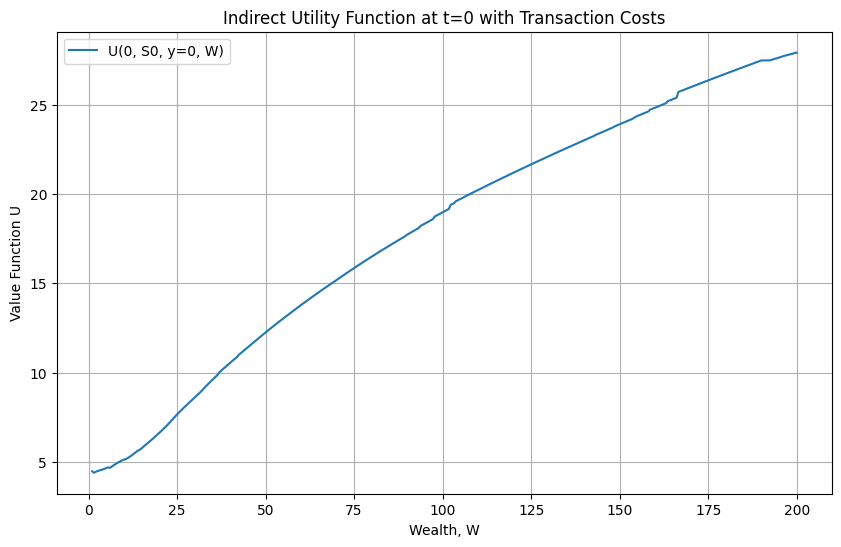

In [98]:
# ------------------------------
# Solve and Plot Transaction Cost Case (Option)
# ------------------------------
U_tc_opt, y_grid_opt = solve_dp_with_transaction_cost(option=True)
k0 = len(y_grid) // 2

plt.figure(figsize=(10, 6))
plt.plot(W_grid, U_tc_opt[(0,0)][k0,:], label="U(0, S0, y=0, W)")
plt.xlabel("Wealth, W")
plt.ylabel("Value Function U")
plt.title("Indirect Utility Function at t=0 with Transaction Costs")
plt.legend()
plt.grid(True)
plt.show()

## 2.3 Indifference pricing

Optimal C = 10.921790500999318


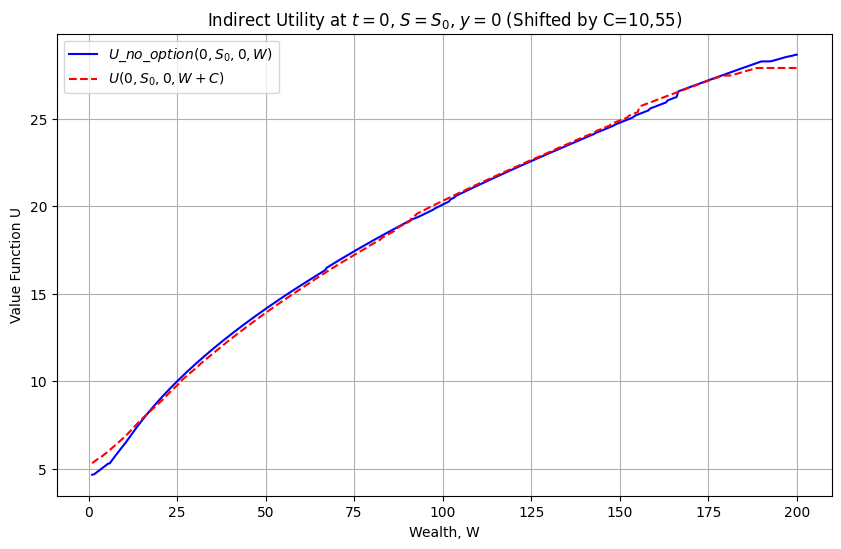

In [99]:
# ------------------------------
# Indifference Pricing with Transaction Costs (Corrected Shift Direction)
# ------------------------------

def shifted_utility_tc(C):
    W_shifted = W_grid + C
    U_shifted = np.interp(W_shifted, W_grid, U_tc_opt[(0, 0)][k0,:])
    error = np.sqrt(np.mean((U_shifted - U_tc[(0, 0)][k0,:])**2))
    return error

res = minimize_scalar(shifted_utility_tc, bounds=(0, 20), method='bounded')
C_optimal_tc = res.x
print("Optimal C =", C_optimal_tc)

C_tc = C_optimal_tc 
W_shifted = W_grid + C_tc
U_shifted = np.interp(W_shifted, W_grid, U_tc_opt[(0, 0)][k0, :])

plt.figure(figsize=(10,6))
plt.plot(W_grid, U_tc[(0,0)][k0,:], 'b-', label=r'$U\_no\_option(0,S_0,0,W)$')
plt.plot(W_grid, U_shifted, 'r--', label=r"$U(0,S_0,0,W+C)$")
plt.xlabel("Wealth, W")
plt.ylabel("Value Function U")
plt.title("Indirect Utility at $t=0$, $S=S_0$, $y=0$ (Shifted by C=10,55)")
plt.legend()
plt.grid(True)
plt.show()

# 3 Comparison between no transaction costs case and tc case

## 3.1 Indirect utilities 

In [100]:
lambda_tc = 0.0

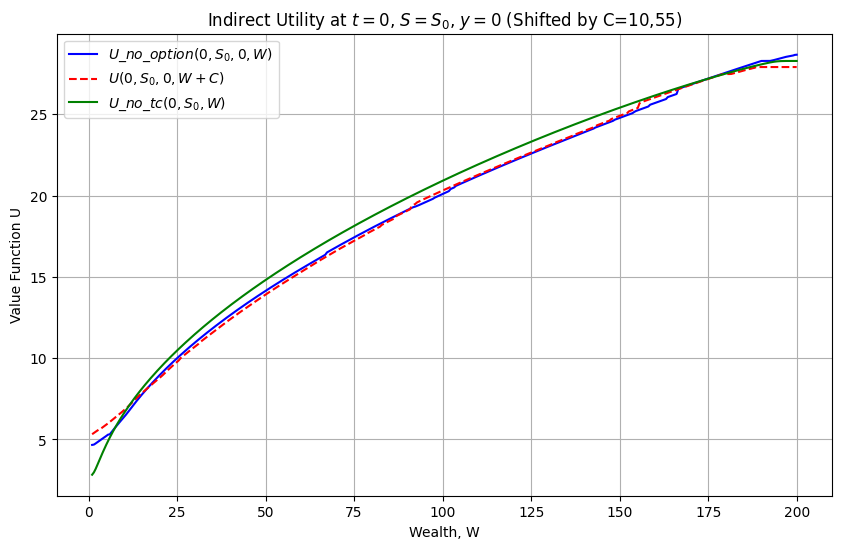

In [101]:
plt.figure(figsize=(10,6))
plt.plot(W_grid, U_tc[(0,0)][k0,:], 'b-', label=r'$U\_no\_option(0,S_0,0,W)$')
plt.plot(W_grid, U_shifted, 'r--', label=r"$U(0,S_0,0,W+C)$")
plt.plot(W_grid, U_no_opt[(0,0)], 'g-', label=r"$U\_no\_tc(0,S_0,W)$")
plt.xlabel("Wealth, W")
plt.ylabel("Value Function U")
plt.title("Indirect Utility at $t=0$, $S=S_0$, $y=0$ (Shifted by C=10,55)")
plt.legend()
plt.grid(True)
plt.show()

## 3.2 Prices

In [102]:
print('The indifference price in the absence of transaction costs is :',C)
print('The indifference price with transaction costs is :',C_tc)

The indifference price in the absence of transaction costs is : 7.676162037612947
The indifference price with transaction costs is : 10.921790500999318


## 3.3 Proportions with no option

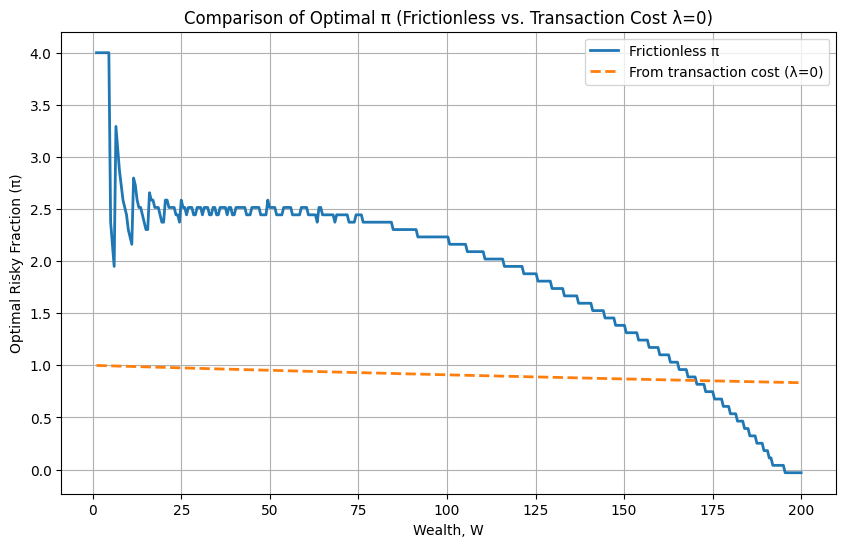

In [103]:
# ------------------------------
# Assumptions
# ------------------------------
W_min, W_max = 1.0, 200.0
N_W = 400
W_grid = np.linspace(W_min, W_max, N_W)
Delta_y = 1.0
M = 10
y_grid = np.arange(-M, M + 1) * Delta_y
S0 = 100
U_tc
Pi_no_opt


# ------------------------------
# Compute π from Transaction Cost (λ = 0)
# ------------------------------

U_matrix = U_tc[(0, 0)]  # shape (N_y, N_W)
k_star_indices = np.argmax(U_matrix, axis=0)
y_star = y_grid[k_star_indices]
Pi_tc_equiv = (y_star * S0) / (W_grid + y_star * S0)

# ------------------------------
# Plot Comparison
# ------------------------------
plt.figure(figsize=(10, 6))
plt.plot(W_grid, Pi_no_opt[(0, 0)], label='Frictionless π', lw=2)
plt.plot(W_grid, Pi_tc_equiv, '--', label='From transaction cost (λ=0)', lw=2)
plt.xlabel("Wealth, W")
plt.ylabel("Optimal Risky Fraction (π)")
plt.title("Comparison of Optimal π (Frictionless vs. Transaction Cost λ=0)")
plt.legend()
plt.grid(True)
plt.show()


## 3.4 Proportion with option

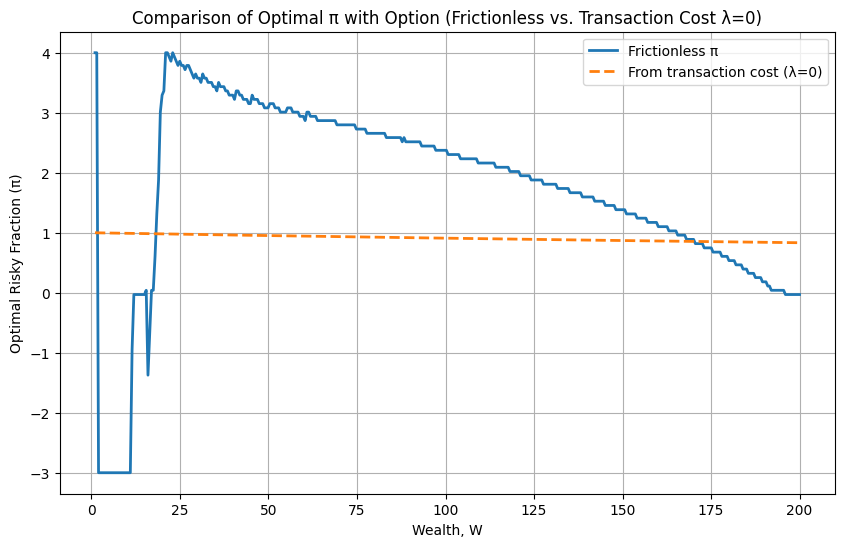

In [104]:
# ------------------------------
# Assumptions
# ------------------------------
W_min, W_max = 1.0, 200.0
N_W = 400
W_grid = np.linspace(W_min, W_max, N_W)
Delta_y = 1.0
M = 10
y_grid = np.arange(-M, M + 1) * Delta_y
S0 = 100
U_tc
Pi_no_opt


# ------------------------------
# Compute π from Transaction Cost (λ = 0)
# ------------------------------

U_matrix = U_tc_opt[(0, 0)]  # shape (N_y, N_W)
k_star_indices = np.argmax(U_matrix, axis=0) 
y_star = y_grid[k_star_indices]
Pi_tc_equiv = (y_star * S0) / (W_grid + y_star * S0)

# ------------------------------
# Plot Comparison
# ------------------------------
plt.figure(figsize=(10, 6))
plt.plot(W_grid, Pi_with_opt[(0, 0)], label='Frictionless π', lw=2)
plt.plot(W_grid, Pi_tc_equiv, '--', label='From transaction cost (λ=0)', lw=2)
plt.xlabel("Wealth, W")
plt.ylabel("Optimal Risky Fraction (π)")
plt.title("Comparison of Optimal π with Option (Frictionless vs. Transaction Cost λ=0)")
plt.legend()
plt.grid(True)
plt.show()
